# Code for model estimation

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

In [11]:
l = 1
set_id = 8
fold_n = 0
#                         /models/darts_retrained/7ch_128x128_no_metainfo_registered_5Fold_newC43_27Nov2020-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs'
validation_file_path="/mnt/models/darts_retrained/4ch_128x128_11inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation7ch_logits_predictions.csv".format(l, set_id, fold_n)
train_file_path=     "/mnt/models/darts_retrained/4ch_128x128_11inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train7ch_logits_predictions.csv".format(l, set_id, fold_n)

df_val = pd.read_csv(validation_file_path, index_col=0)
df_train = pd.read_csv(train_file_path, index_col=0)


In [12]:
df_val

,true_value,pred_value,logit_0,logit_1,logit_2,logit_3,logit_4
0,4.0,1.0,-2.116903,2.854421,-0.925787,-1.708548,1.913511
1,1.0,1.0,-4.197381,3.034883,-0.517409,-0.190279,1.716164
2,4.0,3.0,-1.005905,-2.877287,-1.606423,5.979582,-0.152500
3,3.0,0.0,2.181015,2.097084,-1.380688,-1.270641,-1.460426
4,4.0,4.0,-1.180765,0.323296,-1.420006,-0.751881,3.263540
...,...,...,...,...,...,...,...
296,2.0,4.0,-1.807995,1.178725,0.935139,-1.597405,1.456666
297,2.0,2.0,-4.562430,0.719099,3.958492,-1.879816,1.781473
298,2.0,2.0,-4.951954,1.540747,3.248631,-1.429693,1.727215
299,0.0,4.0,-1.079602,0.362702,-0.351191,-0.185796,1.419004


In [13]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(df_val['true_value'], df_val['pred_value'], average='weighted')

(0.6008971400930004, 0.5880398671096345, 0.5720404967237659, None)

In [14]:
import seaborn as sn

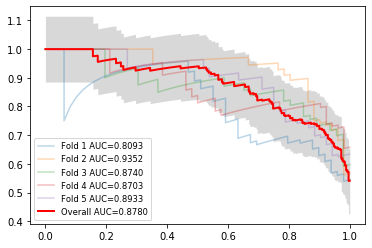

In [15]:
# https://stackoverflow.com/questions/55541254/precision-recall-curve-with-n-fold-cross-validation-showing-standard-deviation

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from numpy import interp
from sklearn.metrics import auc

X, y = make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=10.0,
    random_state=10)

k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
predictor = SVC(kernel='linear', C=1.0, probability=True, random_state=10)

y_real = []
y_proba = []

precision_array = []
threshold_array=[]
recall_array = np.linspace(0, 1, 100)

for i, (train_index, test_index) in enumerate(k_fold.split(X)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision_fold, recall_fold, thresh = precision_recall_curve(ytest, pred_proba[:,1])
    precision_fold, recall_fold, thresh = precision_fold[::-1], recall_fold[::-1], thresh[::-1]  # reverse order of results
    thresh = np.insert(thresh, 0, 1.0)
    precision_array = interp(recall_array, recall_fold, precision_fold)
    threshold_array = interp(recall_array, recall_fold, thresh)
    pr_auc = auc(recall_array, precision_array)

    lab_fold = 'Fold %d AUC=%.4f' % (i+1, pr_auc)
    plt.plot(recall_fold, precision_fold, alpha=0.3, label=lab_fold)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))

plt.plot(recall, precision, lw=2,color='red', label=lab)

plt.legend(loc='lower left', fontsize='small')

mean_precision = np.mean(precision_array)
std_precision = np.std(precision_array)
plt.fill_between(recall, precision + std_precision, precision - std_precision, alpha=0.3, linewidth=0, color='grey')
plt.show()

# Metrics calculation

In [16]:
from sklearn.metrics import roc_auc_score

class MultiClassMetrics():
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        
    def calculate_scores(self, class_mapping_dict=None):
    
        y_true_ = self.y_true
        y_pred_ = self.y_pred
        if classes_map_dict is not None:
            y_true_ = y_true_.map(classes_map_dict)
            y_pred_ = y_pred_.map(classes_map_dict)
    
        self.cnf_matrix = confusion_matrix(y_true_, y_pred_)
        self.FP = self.cnf_matrix.sum(axis=0) - np.diag(self.cnf_matrix) 
        self.FN = self.cnf_matrix.sum(axis=1) - np.diag(self.cnf_matrix)
        self.TP = np.diag(self.cnf_matrix)
        self.TN = self.cnf_matrix.sum() - (self.FP + self.FN + self.TP)
        self.FP = self.FP.astype(float)
        self.FN = self.FN.astype(float)
        self.TP = self.TP.astype(float)
        self.TN = self.TN.astype(float)
        # Sensitivity, hit rate, recall, or true positive rate
        self.TPR = self.TP/(self.TP+self.FN)
        # Specificity or true negative rate
        self.TNR = self.TN/(self.TN+self.FP) 
        # Precision or positive predictive value
        self.PPV = self.TP/(self.TP+self.FP)
        # Negative predictive value
        self.NPV = self.TN/(self.TN+self.FN)
        # Fall out or false positive rate
        self.FPR = self.FP/(self.FP+self.TN)
        # False negative rate
        self.FNR = self.FN/(self.TP+self.FN)
        # False discovery rate
        self.FDR = self.FP/(self.TP+self.FP)
        # Overall accuracy for each class
        self.ACC = (self.TP+self.TN)/(self.TP+self.FP+self.FN+self.TN)

        self.F1_micro = f1_score(y_true_, y_pred_, average='micro')
        self.F1_macro = f1_score(y_true_, y_pred_, average='macro')
        self.F1_weighted = f1_score(y_true_, y_pred_, average='weighted')
        
#         self.AUC = auc(y_true_, y_pred_)

class MultiClassFoldsMetrics():
    def __init__(self, multi_class_metrics_list):
        self.multi_class_metrics_list = multi_class_metrics_list
        
    def calc_scores(self, class_mapping_dict=None, classes_n=None):
#         classes_n = self.multi_class_metrics_list[0].y_true.unique().shape[0]
        folds_n = len(self.multi_class_metrics_list)
        
        self.classes_n = classes_n
        self.folds_n = folds_n
        
        self.TPR_arr = np.zeros((folds_n, classes_n))
        self.TNR_arr = np.zeros((folds_n, classes_n))
        self.PPV_arr = np.zeros((folds_n, classes_n))
        self.NPV_arr = np.zeros((folds_n, classes_n))
        self.FPR_arr = np.zeros((folds_n, classes_n))
        self.FNR_arr = np.zeros((folds_n, classes_n))
        self.FDR_arr = np.zeros((folds_n, classes_n))
        self.ACC_arr = np.zeros((folds_n, classes_n))
        self.F1_micro_arr = np.zeros((folds_n))
        self.F1_macro_arr = np.zeros((folds_n))
        self.F1_weighted_arr = np.zeros((folds_n))
        self.cnf_matrix_arr = np.zeros((classes_n, classes_n))
#         self.AUC_arr = np.zeros((folds_n, classes_n))
        
        fold_n = 0
        for m in self.multi_class_metrics_list:
            m.calculate_scores(class_mapping_dict)

            self.TPR_arr[fold_n,:]=m.TPR
            self.TNR_arr[fold_n,:]=m.TNR
            self.PPV_arr[fold_n,:]=m.PPV
            self.NPV_arr[fold_n,:]=m.NPV
            self.FPR_arr[fold_n,:]=m.FPR
            self.FNR_arr[fold_n,:]=m.FNR
            self.FDR_arr[fold_n,:]=m.FDR
            self.ACC_arr[fold_n,:]=m.ACC
            self.F1_micro_arr[fold_n]=m.F1_micro
            self.F1_macro_arr[fold_n]=m.F1_macro
            self.F1_weighted_arr[fold_n]=m.F1_weighted
            self.cnf_matrix_arr = np.add(self.cnf_matrix_arr, m.cnf_matrix)
            
#             self.AUC_arr = m.AUC
            
            fold_n = fold_n + 1
            
    def print_scores(self):
        print('TPR={}, TNR={}, PPV={}, NPV={}, FPR={}, FNR={}, FDR={}, ACC={}, F1_micro={}, F1_macro={}, F1_weighted={}'.format(  #, AUC={}
                self.TPR_arr.mean(axis=0), 
                self.TNR_arr.mean(axis=0), 
                self.PPV_arr.mean(axis=0), 
                self.NPV_arr.mean(axis=0), 
                self.FPR_arr.mean(axis=0), 
                self.FNR_arr.mean(axis=0), 
                self.FDR_arr.mean(axis=0), 
                self.ACC_arr.mean(axis=0), 
                self.F1_micro_arr.mean(), 
                self.F1_macro_arr.mean(), 
                self.F1_weighted_arr.mean()  #,
#                 self.AUC_arr.mean(axis=0) 
                )
             )
        print('{}'.format(self.cnf_matrix_arr))
        
    def print_mean_classification_report(self, classes_map_dict=None, target_names=None):
        y_true_, y_pred_ = self.collect_ys(classes_map_dict)
        print(classification_report(y_true_, y_pred_, target_names=target_names))
        
    def collect_ys(self, classes_map_dict=None):
        y_true_ = pd.Series()
        y_pred_ = pd.Series()
        for m in self.multi_class_metrics_list:
            __y_tr = m.y_true.copy()
            __y_pr = m.y_pred.copy()
            
            if classes_map_dict is not None:
                __y_tr = __y_tr.map(classes_map_dict)
                __y_pr = __y_pr.map(classes_map_dict)
                
            y_true_ = y_true_.append(__y_tr, ignore_index=True, verify_integrity=False)
            y_pred_ = y_pred_.append(__y_pr, ignore_index=True, verify_integrity=False)
            
        return y_true_, y_pred_
        


In [17]:
def build_multi_class_metrics_list(val_file_template, layer, set_id, folds_n, classes_n):
    
    multi_class_metrics_list = []
    for fold_n in range(folds_n):
        file_path=val_file_template.format(layer, set_id, fold_n)
        df = pd.read_csv(file_path)
        
        true_value = df['true_value']
        pred_value = df['pred_value']
        
        multi_class_metric = MultiClassMetrics(true_value, pred_value)
        multi_class_metrics_list.append(multi_class_metric)
        
    return MultiClassFoldsMetrics(multi_class_metrics_list)

# 4 channels (no white) 128x128, 9 inner channels (DARTS searched for 5 classes classification (Set8))

In [18]:
# val_file_template="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation4_logits_predictions.csv"
# train_file_template="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train4_logits_predictions.csv"
# val_file_template="/mnt/models/darts_retrained/7ch_128x128_no_metainfo_registered_5Fold_newC43_27Nov2020-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation7ch_logits_predictions.csv"
# train_file_template=     "/mnt/models/darts_retrained/7ch_128x128_no_metainfo_registered_5Fold_newC43_27Nov2020-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train7ch_logits_predictions.csv"

# val_file_template="/mnt/models/darts_retrained/7-6ch_128x128_no_metainfo_registered_5Fold_newC43_11Dec2020-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_12inCh_fold-{}/validation7ch_logits_predictions.csv"
# train_file_template=     "/mnt/models/darts_retrained/7-6ch_128x128_no_metainfo_registered_5Fold_newC43_11Dec2020-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_12inCh_fold-{}/train7ch_logits_predictions.csv"
val_file_template="/mnt/models/darts_retrained/4ch_128x128_9inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation7ch_logits_predictions.csv"
train_file_template=     "/mnt/models/darts_retrained/4ch_128x128_9inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train7ch_logits_predictions.csv"



# ClassSet8

In [23]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
TPR=[0.54652681 0.76817782 0.43867021 0.46384433 0.75398612], TNR=[0.98665921 0.86038075 0.971481   0.95813296 0.73111285], PPV=[0.68782051 0.69384314 0.76507558 0.60836374 0.62046747], NPV=[0.97774755 0.90202128 0.88944043 0.92794492 0.83918214], FPR=[0.01334079 0.13961925 0.028519   0.04186704 0.26888715], FNR=[0.45347319 0.23182218 0.56132979 0.53615567 0.24601388], FDR=[0.31217949 0.30615686 0.23492442 0.39163626 0.37953253], ACC=[0.96590168 0.83380825 0.87694102 0.89770659 0.73961943], F1_micro=0.6569884833372311, F1_macro=0.6168768053727592, F1_weighted=0.6475822940894493
[[ 36.  13.   1.   4.  12.]
 [  5. 311.  12.   7.  70.]
 [  2.  39. 108.  15.  84.]
 [ 10.   5.   3.  79.  74.]
 [  1.  82.  17.  25. 383.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.67      0.55      0.60        66
       Pigmented_benign       0.69      0.77      0.73       405
        Keratin_lesions       0.77      0.44      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.64860844 0.88144454 0.58259082 0.60940607 0.84888281], TNR=[0.99192957 0.90181305 0.98889365 0.97109111 0.81816864], PPV=[0.80164436 0.78668548 0.91867642 0.74769195 0.72924619], NPV=[0.98273084 0.9491857  0.91658792 0.94699462 0.90479081], FPR=[0.00807043 0.09818695 0.01110635 0.02890889 0.18183136], FNR=[0.35139156 0.11855546 0.41740918 0.39059393 0.15111719], FDR=[0.19835564 0.21331452 0.08132358 0.25230805 0.27075381], ACC=[0.97569509 0.89588487 0.91681922 0.92683462 0.82929761], F1_micro=0.7722657010350924, F1_macro=0.7424428108867763, F1_weighted=0.767590457102974
[[1.710e+02 4.200e+01 1.000e+00 1.400e+01 3.600e+01]
 [1.900e+01 1.428e+03 1.300e+01 2.100e+01 1.390e+02]
 [4.000e+00 1.070e+02 5.780e+02 5.200e+01 2.510e+02]
 [1.600e+01 1.700e+01 1.300e+01 4.170e+02 2.210e+02]
 [4.000e+00 2.240e+02 2.400e+01 5.500e+01 1.725e+03]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.80      0.65      0.72       264
       Pigmented_be

TPR=[0.60077749 0.94970307], TNR=[0.94970307 0.60077749], PPV=[0.72711802 0.92124835], NPV=[0.92124835 0.72711802], FPR=[0.05029693 0.39922251], FNR=[0.39922251 0.05029693], FDR=[0.27288198 0.07875165], ACC=[0.89044774 0.89044774], F1_micro=0.8904477410260926, F1_macro=0.7925866846060995, F1_weighted=0.8866692437757964
[[ 142.   95.]
 [  58. 1103.]]
              precision    recall  f1-score   support

  MLL+NonMSC       0.71      0.60      0.65       237
 PB+KL+Other       0.92      0.95      0.94      1161

    accuracy                           0.89      1398
   macro avg       0.82      0.77      0.79      1398
weighted avg       0.88      0.89      0.89      1398

--------------------------------
--------------------------------
--------------------------------
Training:
TPR=[0.87053362 0.9364486  0.76681603 0.72628654 0.88076585], TNR=[0.9906285  0.93392665 0.98519686 0.98595757 0.90214999], PPV=[0.82654207 0.85336405 0.92072453 0.88093178 0.83818686], NPV=[0.99359149 0.97315556

FileNotFoundError: [Errno 2] File /mnt/models/darts_retrained/4ch_128x128_11inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_4lrs_15Dec_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-0/validation7ch_logits_predictions.csv does not exist: '/mnt/models/darts_retrained/4ch_128x128_11inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_4lrs_15Dec_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-0/validation7ch_logits_predictions.csv'

### 5 - layers have best TPR for clas MLL

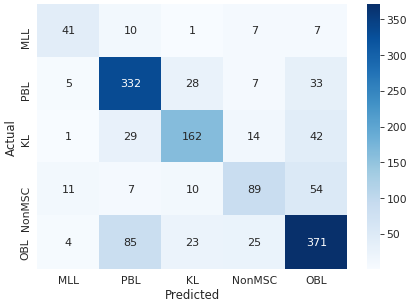

In [37]:
# New Data

data = np.array([[ 41.,  10.,   1.,   7.,   7.],
                 [  5., 332.,  28.,   7.,  33.],
                 [  1.,  29., 162.,  14.,  42.],
                 [ 11.,   7.,  10.,  89.,  54.],
                 [  4.,  85.,  23. , 25., 371.]])
# # 4 layers
# data = np.array([[ 43.,   8.,   1.,   4.,  10.],
#                  [  7., 320.,  22.,   6.,  50.],
#                  [  2.,  31., 161.,   9.,  45.],
#                  [  9.,   2.,  13., 105.,  42.],
#                  [ 10.,  69.,  22.,  30., 377.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

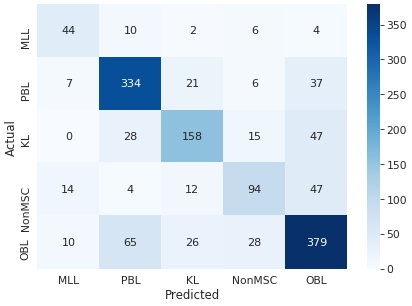

In [29]:
# Journal Submitted data
data = np.array([[ 44.,  10.,   2.,   6.,   4.],
                 [  7., 334.,  21.,   6.,  37.],
                 [  0.,  28., 158.,  15.,  47.],
                 [ 14.,   4.,  12.,  94.,  47.],
                 [ 10.,  65.,  26.,  28., 379.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

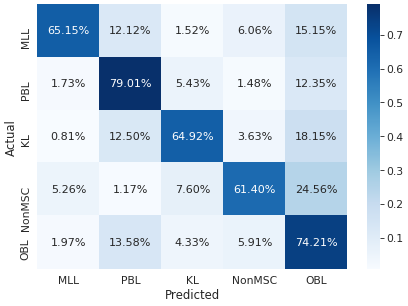

In [43]:
# New Data

# data = np.array([[ 41.,  10.,   1.,   7.,   7.],
#                  [  5., 332.,  28.,   7.,  33.],
#                  [  1.,  29., 162.,  14.,  42.],
#                  [ 11.,   7.,  10.,  89.,  54.],
#                  [  4.,  85.,  23. , 25., 371.]])
# 4 layers
data = np.array([[ 43.,   8.,   1.,   4.,  10.],
                 [  7., 320.,  22.,   6.,  50.],
                 [  2.,  31., 161.,   9.,  45.],
                 [  9.,   2.,  13., 105.,  42.],
                 [ 10.,  69.,  22.,  30., 377.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%

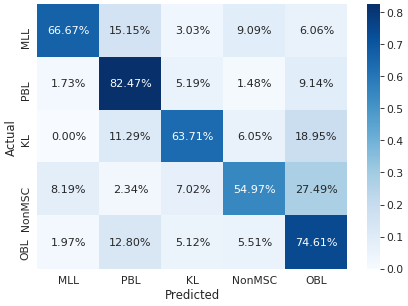

In [30]:
# Journal submitted data
data = np.array([[ 44.,  10.,   2.,   6.,   4.],
                 [  7., 334.,  21.,   6.,  37.],
                 [  0.,  28., 158.,  15.,  47.],
                 [ 14.,   4.,  12.,  94.,  47.],
                 [ 10.,  65.,  26.,  28., 379.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%

## ClassSet8 - NonMSC vs rest

In [39]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
#         multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
    
        print('--------------------------------')    
        print('NonMSC vs MLL+PB+KL+Other:')
        classes_map_dict={0:0, 1:0, 2:0, 3:1, 4:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+PB+KL+Other', 'NonMSC'])
        
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
        
        print('--------------------------------')    
        print('NonMSC vs MLL+PB+KL+Other:')
        classes_map_dict={0:0, 1:0, 2:0, 3:1, 4:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+PB+KL+Other', 'NonMSC'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.96003845 0.44991087], TNR=[0.44991087 0.96003845], PPV=[0.92615019 0.62636201], NPV=[0.62636201 0.92615019], FPR=[0.55008913 0.03996155], FNR=[0.03996155 0.55008913], FDR=[0.07384981 0.37363799], ACC=[0.89751296 0.89751296], F1_micro=0.8975129562190153, F1_macro=0.7281634561113209, F1_weighted=0.8900797076336524
[[1178.   49.]
 [  94.   77.]]
                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.93      0.96      0.94      1227
         NonMSC       0.61      0.45      0.52       171

       accuracy                           0.90      1398
      macro avg       0.77      0.71      0.73      1398
   weighted avg       0.89      0.90      0.89      1398

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.97800977 0.58920789], TNR=[0.58920789 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.94652051 0.561735  ], TNR=[0.561735   0.94652051], PPV=[0.93943176 0.60799103], NPV=[0.60799103 0.93943176], FPR=[0.438265   0.05347949], FNR=[0.05347949 0.438265  ], FDR=[0.06056824 0.39200897], ACC=[0.8994001 0.8994001], F1_micro=0.8994000983809801, F1_macro=0.7604802491289633, F1_weighted=0.898095008713869
[[1162.   65.]
 [  75.   96.]]
                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.94      0.95      0.94      1227
         NonMSC       0.60      0.56      0.58       171

       accuracy                           0.90      1398
      macro avg       0.77      0.75      0.76      1398
   weighted avg       0.90      0.90      0.90      1398

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.97966059 0.86096407], TNR=[0.86096407 0.97966059], PPV=[0.98063738 0.8

### 2 layers seems the best (based on TPR for NonMSC class (MLL+PB+KL+Other is good))

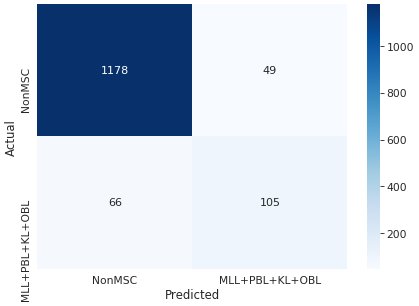

In [18]:
# New data
data = np.array([[1178.,   49.],
                 [  66.,  105.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

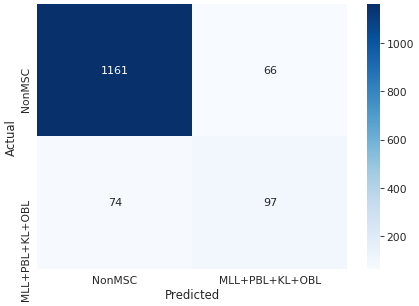

In [17]:
# Submitted to journal
data = np.array([[1161.,  66.],
                 [ 74.,  97.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

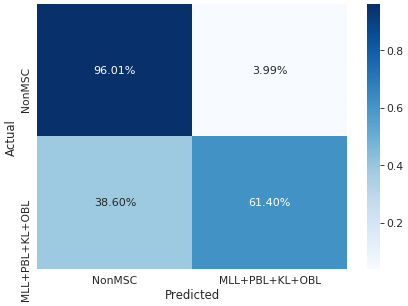

In [19]:
# New data
data = np.array([[1178.,   49.],
                 [  66.,  105.]])

if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%

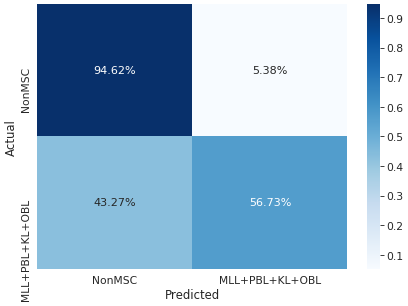

In [34]:
# Submitted to journal
data = np.array([[1161.,  66.],
                 [ 74.,  97.]])

if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%

# 4 channels (no white) 128x128, 11 inner channels (DARTS searched for 5 classes classification (Set8))

In [20]:
# val_file_template="/mnt/models/darts_retrained/4ch_128x128_no_metainfo_registered_5Fold_newC43_11Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_10Dec_newC43NoDup_ClassSet{}_ManCorected_registered_500epochs_fold-{}/validation7ch_logits_predictions.csv"
# train_file_template=     "/mnt/models/darts_retrained/4ch_128x128_no_metainfo_registered_5Fold_newC43_11Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_10Dec_newC43NoDup_ClassSet{}_ManCorected_registered_500epochs_fold-{}/train7ch_logits_predictions.csv"

val_file_template="/mnt/models/darts_retrained/4ch_128x128_11inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation7ch_logits_predictions.csv"
train_file_template=     "/mnt/models/darts_retrained/4ch_128x128_11inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train7ch_logits_predictions.csv"




In [22]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
TPR=[0.54652681 0.76817782 0.43867021 0.46384433 0.75398612], TNR=[0.98665921 0.86038075 0.971481   0.95813296 0.73111285], PPV=[0.68782051 0.69384314 0.76507558 0.60836374 0.62046747], NPV=[0.97774755 0.90202128 0.88944043 0.92794492 0.83918214], FPR=[0.01334079 0.13961925 0.028519   0.04186704 0.26888715], FNR=[0.45347319 0.23182218 0.56132979 0.53615567 0.24601388], FDR=[0.31217949 0.30615686 0.23492442 0.39163626 0.37953253], ACC=[0.96590168 0.83380825 0.87694102 0.89770659 0.73961943], F1_micro=0.6569884833372311, F1_macro=0.6168768053727592, F1_weighted=0.6475822940894493
[[ 36.  13.   1.   4.  12.]
 [  5. 311.  12.   7.  70.]
 [  2.  39. 108.  15.  84.]
 [ 10.   5.   3.  79.  74.]
 [  1.  82.  17.  25. 383.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.67      0.55      0.60        66
       Pigmented_benign       0.69      0.77      0.73       405
        Keratin_lesions       0.77      0.44      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.64860844 0.88144454 0.58259082 0.60940607 0.84888281], TNR=[0.99192957 0.90181305 0.98889365 0.97109111 0.81816864], PPV=[0.80164436 0.78668548 0.91867642 0.74769195 0.72924619], NPV=[0.98273084 0.9491857  0.91658792 0.94699462 0.90479081], FPR=[0.00807043 0.09818695 0.01110635 0.02890889 0.18183136], FNR=[0.35139156 0.11855546 0.41740918 0.39059393 0.15111719], FDR=[0.19835564 0.21331452 0.08132358 0.25230805 0.27075381], ACC=[0.97569509 0.89588487 0.91681922 0.92683462 0.82929761], F1_micro=0.7722657010350924, F1_macro=0.7424428108867763, F1_weighted=0.767590457102974
[[1.710e+02 4.200e+01 1.000e+00 1.400e+01 3.600e+01]
 [1.900e+01 1.428e+03 1.300e+01 2.100e+01 1.390e+02]
 [4.000e+00 1.070e+02 5.780e+02 5.200e+01 2.510e+02]
 [1.600e+01 1.700e+01 1.300e+01 4.170e+02 2.210e+02]
 [4.000e+00 2.240e+02 2.400e+01 5.500e+01 1.725e+03]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.80      0.65      0.72       264
       Pigmented_be

TPR=[0.64237762 0.82016694 0.55629411 0.4922757  0.71583549], TNR=[0.98362699 0.8662524  0.95060305 0.95709886 0.8049965 ], PPV=[0.67680375 0.71552939 0.71282784 0.63975432 0.67763246], NPV=[0.98215046 0.92251185 0.90929547 0.93147129 0.8330503 ], FPR=[0.01637301 0.1337476  0.04939695 0.04290114 0.1950035 ], FNR=[0.35762238 0.17983306 0.44370589 0.5077243  0.28416451], FDR=[0.32319625 0.28447061 0.28717216 0.36024568 0.32236754], ACC=[0.967365   0.85297017 0.88065974 0.90023203 0.77250107], F1_micro=0.6868640064091001, F1_macro=0.654348592666923, F1_weighted=0.6805571172763162
[[ 42.  11.   1.   3.   9.]
 [  4. 332.  20.   5.  44.]
 [  1.  34. 138.  15.  60.]
 [ 13.   5.   8.  84.  61.]
 [  4.  84.  28.  29. 363.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.66      0.64      0.65        66
       Pigmented_benign       0.71      0.82      0.76       405
        Keratin_lesions       0.71      0.56      0.62       248
Nonmelanoma_sk

FileNotFoundError: [Errno 2] File /mnt/models/darts_retrained/4ch_128x128_11inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_4lrs_15Dec_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-0/validation7ch_logits_predictions.csv does not exist: '/mnt/models/darts_retrained/4ch_128x128_11inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_4lrs_15Dec_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-0/validation7ch_logits_predictions.csv'

# Layers 5 - the best counting on TPR (and F1 weighted)

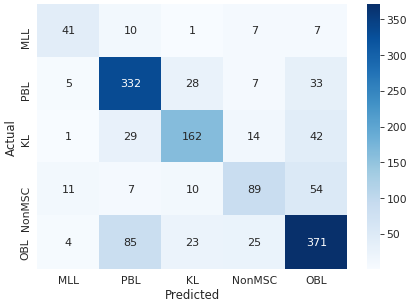

In [26]:
# New Data

data = np.array([[ 41.,  10.,   1.,   7.,   7.],
                 [  5., 332.,  28.,   7.,  33.],
                 [  1.,  29., 162.,  14.,  42.],
                 [ 11.,   7.,  10.,  89.,  54.],
                 [  4.,  85.,  23.,  25., 371.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

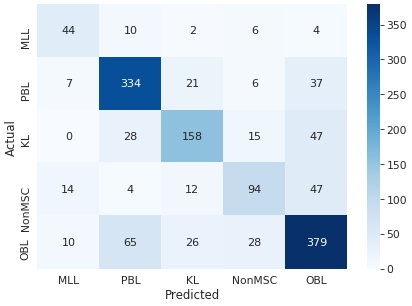

In [27]:
# Journal Submitted data
data = np.array([[ 44.,  10.,   2.,   6.,   4.],
                 [  7., 334.,  21.,   6.,  37.],
                 [  0.,  28., 158.,  15.,  47.],
                 [ 14.,   4.,  12.,  94.,  47.],
                 [ 10.,  65.,  26.,  28., 379.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

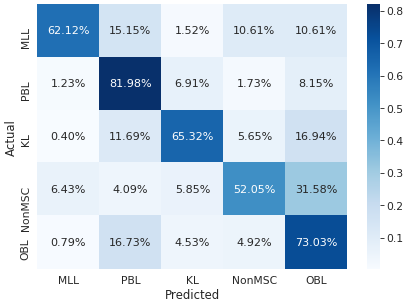

In [28]:
# New Data

data = np.array([[ 41.,  10.,   1.,   7.,   7.],
                 [  5., 332.,  28.,   7.,  33.],
                 [  1.,  29., 162.,  14.,  42.],
                 [ 11.,   7.,  10.,  89.,  54.],
                 [  4.,  85.,  23.,  25., 371.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%

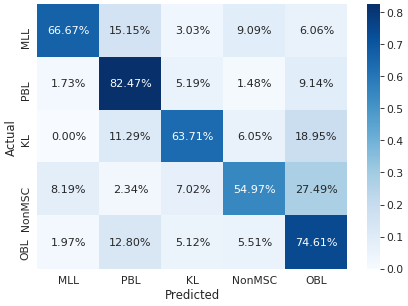

In [29]:
# Journal submitted data
data = np.array([[ 44.,  10.,   2.,   6.,   4.],
                 [  7., 334.,  21.,   6.,  37.],
                 [  0.,  28., 158.,  15.,  47.],
                 [ 14.,   4.,  12.,  94.,  47.],
                 [ 10.,  65.,  26.,  28., 379.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%

## ClassSet8 - NonMSC vs rest

In [30]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
#         multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
    
        print('--------------------------------')    
        print('NonMSC vs MLL+PB+KL+Other:')
        classes_map_dict={0:0, 1:0, 2:0, 3:1, 4:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+PB+KL+Other', 'NonMSC'])
        
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
        
        print('--------------------------------')    
        print('NonMSC vs MLL+PB+KL+Other:')
        classes_map_dict={0:0, 1:0, 2:0, 3:1, 4:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+PB+KL+Other', 'NonMSC'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.96003845 0.44991087], TNR=[0.44991087 0.96003845], PPV=[0.92615019 0.62636201], NPV=[0.62636201 0.92615019], FPR=[0.55008913 0.03996155], FNR=[0.03996155 0.55008913], FDR=[0.07384981 0.37363799], ACC=[0.89751296 0.89751296], F1_micro=0.8975129562190153, F1_macro=0.7281634561113209, F1_weighted=0.8900797076336524
[[1178.   49.]
 [  94.   77.]]
                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.93      0.96      0.94      1227
         NonMSC       0.61      0.45      0.52       171

       accuracy                           0.90      1398
      macro avg       0.77      0.71      0.73      1398
   weighted avg       0.89      0.90      0.89      1398

--------------------------------
--------------------------------
--------------------------------
Training:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.97800977 0.58920789], TNR=[0.58920789 0.97800977], PPV=[0.94480377 0.78764703], NPV=[0.78764703 0.94480377], FPR=[0.41079211 0.02199023], FNR=[0.02199023 0.41079211], FDR=[0.05519623 0.21235297], ACC=[0.93045866 0.93045866], F1_micro=0.9304586646994457, F1_macro=0.8166005429594613, F1_weighted=0.925750331711409
[[4800.  108.]
 [ 281.  403.]]
                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.94      0.98      0.96      4908
         NonMSC       0.79      0.59      0.67       684

       accuracy                           0.93      5592
      macro avg       0.87      0.78      0.82      5592
   weighted avg       0.93      0.93      0.93      5592

--------------------------------
--------------------------------
Layers-2, Set-8
Validation:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.94652051 0.561735  ], TNR=[0.561735   0.94652051], PPV=[0.93943176 0.60799103], NPV

### 2 layers seems the best (based on TPR for NonMSC class (MLL+PB+KL+Other is good))

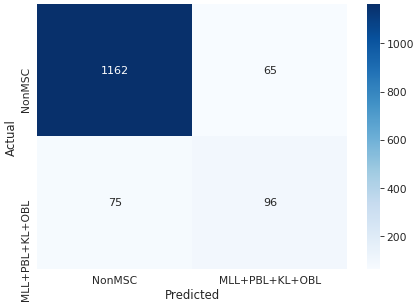

In [31]:
# New data
data = np.array([[1162.,   65.],
                 [  75.,   96.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

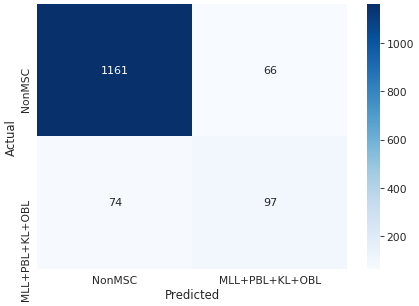

In [32]:
# Submitted to journal
data = np.array([[1161.,  66.],
                 [ 74.,  97.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

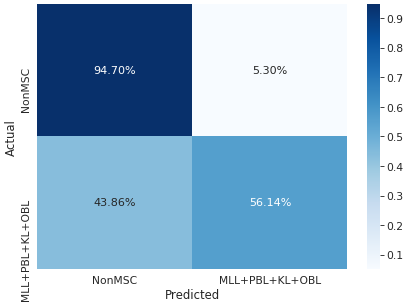

In [35]:
# New data
data = np.array([[1162.,   65.],
                 [  75.,   96.]])

if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%

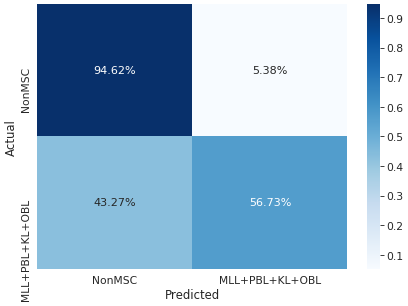

In [34]:
# Submitted to journal
data = np.array([[1161.,  66.],
                 [ 74.,  97.]])

if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%

# 6 channels (no white) 192x192, 12 inner channels (DARTS searched for 5 classes classification (Set8))

In [14]:
# val_file_template="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation4_logits_predictions.csv"
# train_file_template="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train4_logits_predictions.csv"
# val_file_template="/mnt/models/darts_retrained/7ch_128x128_no_metainfo_registered_5Fold_newC43_27Nov2020-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation7ch_logits_predictions.csv"
# train_file_template=     "/mnt/models/darts_retrained/7ch_128x128_no_metainfo_registered_5Fold_newC43_27Nov2020-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train7ch_logits_predictions.csv"

# val_file_template="/mnt/models/darts_retrained/5ch_192x192_12inchannel_no_metainfo_registered_5Fold_newC43_12Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_12Dec_newC43NoDup_ClassSet{}_ManCorected_registered_500epochs_fold-{}/validation7ch_logits_predictions.csv"
# train_file_template=     "/mnt/models/darts_retrained/5ch_192x192_12inchannel_no_metainfo_registered_5Fold_newC43_12Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_12Dec_newC43NoDup_ClassSet{}_ManCorected_registered_500epochs_fold-{}/train7ch_logits_predictions.csv"
val_file_template="/mnt/models/darts_retrained/4ch_128x128_12inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation7ch_logits_predictions.csv"
train_file_template=     "/mnt/models/darts_retrained/4ch_128x128_12inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train7ch_logits_predictions.csv"



In [24]:
val_file_template

'/mnt/models/darts_retrained/4ch_128x128_12inchannel_no_metainfo_registered_5Fold_newC43_15Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation7ch_logits_predictions.csv'

# ClasSet 8

In [15]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
TPR=[0.56675991 0.78489583 0.53494788 0.48585859 0.72864864], TNR=[0.989589   0.863478   0.93851807 0.95958454 0.78899405], PPV=[0.74195527 0.7016498  0.64960091 0.64348037 0.6666448 ], NPV=[0.97866026 0.90851468 0.90402086 0.93046928 0.8354239 ], FPR=[0.010411   0.136522   0.06148193 0.04041546 0.21100595], FNR=[0.43324009 0.21510417 0.46505212 0.51414141 0.27135136], FDR=[0.25804473 0.2983502  0.35039909 0.35651963 0.3333552 ], ACC=[0.96949882 0.84059974 0.86684963 0.90160705 0.76712155], F1_micro=0.6728383939691805, F1_macro=0.6403350628312131, F1_weighted=0.6669949615461059
[[ 37.  14.   3.   7.   5.]
 [  4. 318.  20.   5.  58.]
 [  1.  34. 132.  14.  67.]
 [  7.   9.  14.  83.  58.]
 [  2.  79.  34.  23. 370.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.73      0.56      0.63        66
       Pigmented_benign       0.70      0.79      0.74       405
        Keratin_lesions       0.65      0.53      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.56646424 0.95745958], TNR=[0.95745958 0.56646424], PPV=[0.73709478 0.91544271], NPV=[0.91544271 0.73709478], FPR=[0.04254042 0.43353576], FNR=[0.43353576 0.04254042], FDR=[0.26290522 0.08455729], ACC=[0.89112782 0.89112782], F1_micro=0.8911278163451529, F1_macro=0.7871197618033384, F1_weighted=0.8854564825603329
[[ 134.  103.]
 [  49. 1112.]]
              precision    recall  f1-score   support

  MLL+NonMSC       0.73      0.57      0.64       237
 PB+KL+Other       0.92      0.96      0.94      1161

    accuracy                           0.89      1398
   macro avg       0.82      0.76      0.79      1398
weighted avg       0.88      0.89      0.89      1398

--------------------------------
--------------------------------
--------------------------------
Training:
TPR=[0.71998898 0.89563127 0.72617845 0.67957944 0.84608919], TNR=[0.99306605 0.91413892 0.97068124 0.98128673 0.87587312], PPV=[0.8379143  0.81051636 0.84494342 0.8374716  0.79728197], NPV=[0.98621201 0.95556096

TPR=[0.9206653  0.98968301], TNR=[0.98968301 0.9206653 ], PPV=[0.94844808 0.98394169], NPV=[0.98394169 0.94844808], FPR=[0.01031699 0.0793347 ], FNR=[0.0793347  0.01031699], FDR=[0.05155192 0.01605831], ACC=[0.97797897 0.97797897], F1_micro=0.9779789718847995, F1_macro=0.9603488640215039, F1_weighted=0.9778225777980074
[[ 873.   75.]
 [  48. 4596.]]
              precision    recall  f1-score   support

  MLL+NonMSC       0.95      0.92      0.93       948
 PB+KL+Other       0.98      0.99      0.99      4644

    accuracy                           0.98      5592
   macro avg       0.97      0.96      0.96      5592
weighted avg       0.98      0.98      0.98      5592

--------------------------------
--------------------------------
Layers-3, Set-8
Validation:
TPR=[0.62699301 0.79493638 0.56374443 0.49426619 0.75352752], TNR=[0.97539662 0.88462481 0.96100954 0.9658465  0.78203885], PPV=[0.59219716 0.73835783 0.7550267  0.7028668  0.66843185], NPV=[0.98130947 0.91398376 0.91105568 0.9

TPR=[0.97350157 0.95240447 0.93555742 0.89897552 0.94987567], TNR=[0.99380578 0.98313827 0.98715529 0.99146462 0.96679555], PPV=[0.88658444 0.958793   0.94033526 0.93669782 0.94238306], NPV=[0.99868161 0.98060711 0.98611216 0.98599792 0.97140122], FPR=[0.00619422 0.01686173 0.01284471 0.00853538 0.03320445], FNR=[0.02649843 0.04759553 0.06444258 0.10102448 0.05012433], FDR=[0.11341556 0.041207   0.05966474 0.06330218 0.05761694], ACC=[0.99284809 0.97421457 0.97799501 0.98014029 0.96063462], F1_micro=0.9429162887739606, F1_macro=0.9368662913089375, F1_weighted=0.9428913011470075
[[ 257.    0.    0.    5.    2.]
 [  10. 1543.   19.    9.   39.]
 [   5.   10.  928.   17.   32.]
 [  13.    0.   11.  615.   45.]
 [   5.   57.   29.   11. 1930.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.89      0.97      0.93       264
       Pigmented_benign       0.96      0.95      0.96      1620
        Keratin_lesions       0.94      0.94      0.9

              precision    recall  f1-score   support

  MLL+NonMSC       0.93      0.87      0.90       948
 PB+KL+Other       0.97      0.99      0.98      4644

    accuracy                           0.97      5592
   macro avg       0.95      0.93      0.94      5592
weighted avg       0.97      0.97      0.97      5592

--------------------------------
--------------------------------


## Seems 2 layers is the best result

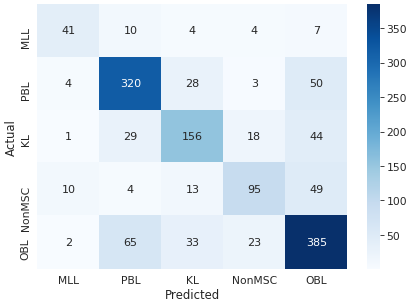

In [17]:
# New Data

data = np.array([[ 41.,  10.,   4.,   4.,   7.],
                 [  4., 320.,  28.,   3.,  50.],
                 [  1.,  29., 156.,  18.,  44.],
                 [ 10.,   4.,  13.,  95.,  49.],
                 [  2.,  65.,  33.,  23., 385.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

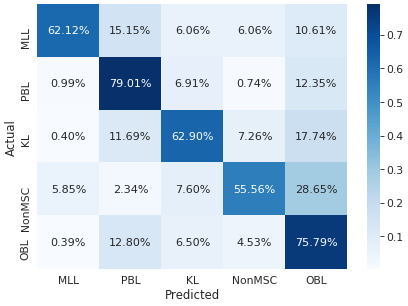

In [18]:
# New Data

data = np.array([[ 41.,  10.,   4.,   4.,   7.],
                 [  4., 320.,  28.,   3.,  50.],
                 [  1.,  29., 156.,  18.,  44.],
                 [ 10.,   4.,  13.,  95.,  49.],
                 [  2.,  65.,  33.,  23., 385.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%

## ClassSet8 - NonMSC vs rest

In [19]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
#         multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
    
        print('--------------------------------')    
        print('NonMSC vs MLL+PB+KL+Other:')
        classes_map_dict={0:0, 1:0, 2:0, 3:1, 4:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+PB+KL+Other', 'NonMSC'])
        
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
        
        print('--------------------------------')    
        print('NonMSC vs MLL+PB+KL+Other:')
        classes_map_dict={0:0, 1:0, 2:0, 3:1, 4:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+PB+KL+Other', 'NonMSC'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.95958454 0.48585859], TNR=[0.48585859 0.95958454], PPV=[0.93046928 0.64348037], NPV=[0.64348037 0.93046928], FPR=[0.51414141 0.04041546], FNR=[0.04041546 0.51414141], FDR=[0.06953072 0.35651963], ACC=[0.90160705 0.90160705], F1_micro=0.9016070456986645, F1_macro=0.7467964810539743, F1_weighted=0.8962110417340682
[[1178.   49.]
 [  88.   83.]]
                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.93      0.96      0.95      1227
         NonMSC       0.63      0.49      0.55       171

       accuracy                           0.90      1398
      macro avg       0.78      0.72      0.75      1398
   weighted avg       0.89      0.90      0.90      1398

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
NonMSC vs MLL+PB+KL+Other:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.98128673 0.67957944], TNR=[0.67957944 0.98128673], PPV=[0.95651785 0.8374716 ], NPV=[0.8374716  0.95651785], FPR=[0.32042056 0.01871327], FNR=[0.01871327 0.32042056], FDR=[0.04348215 0.1625284 ], ACC=[0.94435295 0.94435295], F1_micro=0.9443529459342447, F1_macro=0.858483416585982, F1_weighted=0.9417327784253701
[[4816.   92.]
 [ 219.  465.]]
                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.96      0.98      0.97      4908
         NonMSC       0.83      0.68      0.75       684

       accuracy                           0.94      5592
      macro avg       0.90      0.83      0.86      5592
   weighted avg       0.94      0.94      0.94      5592

--------------------------------
--------------------------------
Layers-2, Set-8
Validation:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.96097793 0.55733809], TNR=[0.55733809 0.96097793], PPV=[0.93990283 0.66679654], NPV=[0.66679654 0.93990283], FPR=[0.44266191 0.03902207], FNR=[

### 2 layers is the best 

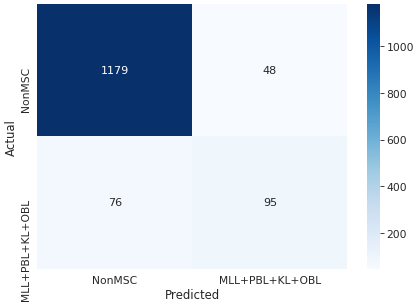

In [20]:
# New data
data = np.array([[1179.,   48.],
                 [  76.,   95.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

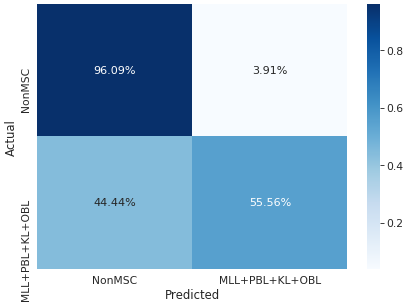

In [21]:
# New data
data = np.array([[1179.,   48.],
                 [  76.,   95.]])

if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%